In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp
from scipy import optimize
from tqdm import tqdm

from interaction import potential
from counterterm import local_LO_counterterm
from constants import MU, BETA4
from utility import log_mesh

plt.style.use('science')
ratio = 4/3
h = 3

In [2]:
mm = np.loadtxt('spectrum_Mott_Massey_hp_coord.txt')
b2_mm = np.abs(mm)
gamma_mm = np.sqrt(2*MU*b2_mm)
r0_mm = -1/gamma_mm * np.log(1e-10)

In [3]:
DEFAULT_R_0 = 50
DEFAULT_ENDPTS = np.array([1e-3, 100])
INIT_CONDITIONS = np.array([0, 1])

# Solves the radial (u) Schrödinger equation and returns arrays of r and u.
def solve_se(v_r, energy, rmin=1e-9, rmax=50.0, numpts=10000):
    r_values = np.linspace(rmin, rmax, numpts)
    g = lambda u, r: np.array([u[1], (2 * MU) * (v_r(r) - energy) * u[0]])
    w = odeint(g, INIT_CONDITIONS, r_values, mxstep=20000)
    return (r_values, w[:, 0])


def wave_function(v_r, energy, r_endpts=DEFAULT_ENDPTS):
    sol = solve_ivp(
        lambda r, phi: np.array([phi[1], 2*MU*(v_r(r) - energy) * phi[0]], dtype=object),
        r_endpts, [r_endpts[0], 1], rtol=1e-8, atol=1e-12,
        dense_output=True
    )
    return sol.sol


def normalization_constant(v_r, energy, r_max=100, tol=1e-12):
    r, wr = log_mesh(0, r_max, 3000)
    u = wave_function(v_r, energy)(r)[0]
    iC2 = np.dot(wr, u**2)
    return 1/np.sqrt(iC2)


def normalized_wave_function(v_r, energy, r_max=100, tol=1e-12):
    r, wr = log_mesh(0, r_max, 3000)
    u = wave_function(v_r, energy)(r)[0]
    iC2 = np.dot(wr, u**2)
    return 1/np.sqrt(iC2) * u


def f(energy, interaction,  r_0=DEFAULT_R_0, r_endpts=DEFAULT_ENDPTS):
    sol = wave_function(interaction, energy, r_endpts=r_endpts)
    return sol(r_0)[0]


def D(energy, interaction, r_0, endpts=DEFAULT_ENDPTS):
    sol = wave_function(interaction, energy, r_endpts=[1e-3, 1.1*r_0])
    u, up = sol(r_0)
    gamma = np.sqrt(2*MU*-energy)
    return gamma*u + up


def bound_state(interaction, guess, r_0=DEFAULT_R_0, r_endpts=DEFAULT_ENDPTS):
    result = optimize.fsolve(lambda en: D(en, interaction, r_0, endpts=r_endpts), guess)
    return result[0]

In [4]:
NUM_STATES = 14

In [5]:
rgf_lo = np.loadtxt(f'rgflow_local_lo_a0_fix_hp_n_14_coord_ir_corrected.txt')
spectra_lo = np.loadtxt(f'spectra_local_lo_a0_fix_hpp_n_14.txt')

In [6]:
old_rgf_lo = np.loadtxt('rgflow_local_lo_a0_fix_hp_n_14_coord.txt')

In [7]:
n = rgf_lo.shape[0]

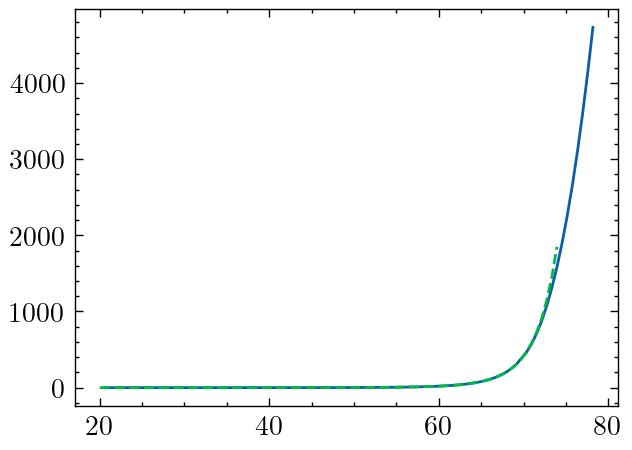

In [8]:
fig, ax = plt.subplots(dpi=200)
fig.patch.set_facecolor('white')

ax.plot(BETA4/rgf_lo[:, 0], rgf_lo[:, 1])
ax.plot(BETA4/old_rgf_lo[:n, 0], old_rgf_lo[:n, 1], linestyle='--');

In [9]:
R_MESH = log_mesh(1e-3, 4, 4000)

class NLOResult:
    def __init__(self, R, c_0, spec_lo_momentum, r_mesh=R_MESH, **kwargs_bound_state):
        self.R = R
        self.c_0 = c_0
        self.spec_lo_mom = spec_lo_momentum.copy()
        self.k_lo_mom = np.sqrt(2*MU*-self.spec_lo_mom)
        r, wr = r_mesh
        
        self.potential = lambda r: potential(r, self.R) + self.c_0*local_LO_counterterm(r, self.R)
        self.spec_lo = np.array([
            bound_state(self.potential, en, r_0=r0) for (en, r0) in zip(self.spec_lo_mom, r0_mm)])
        self.b2_lo = np.abs(self.spec_lo)
            
        self.integrands = []
        self.matrix_elements = []
        self.norm_constants = []
        self.solutions = []

        for ((i, en), r0) in zip(enumerate(self.spec_lo), r0_mm):
            C = normalization_constant(self.potential, en, r_max=r0)
            self.norm_constants.append(C)
            
            sol = wave_function(self.potential, en)
            self.solutions.append(sol)
            
            r, wr = R_MESH
            u = C*sol(r)[0]
            integrand = local_LO_counterterm(r, R)*u**2
            self.integrands.append(integrand)
            self.matrix_elements.append(np.dot(wr, integrand))
        
        self.integrands = np.array(self.integrands)
        self.matrix_elements = np.array(self.matrix_elements)
        
        self.c_2 = 1/self.matrix_elements[-1] * (b2_mm[-1]/self.b2_lo[-1] - 1)
        self.b2_nlo = self.b2_lo * (1 + self.c_2*self.matrix_elements)

In [10]:
from scipy.interpolate import interp1d

In [11]:
def good_guess(cutoffs, spec_history, next_cutoff):
    interp_funcs = [interp1d(cutoffs, row, kind='cubic', fill_value='extrapolate') for row in spec_history.T]
    return np.array([f(next_cutoff) for f in interp_funcs])

In [12]:
results = []

for i in tqdm(range(rgf_lo.shape[0]-1)):
    R, c0 = rgf_lo[i]
    
    if i < 6:
        spec_guess = spectra_lo[i, 1:]
    else:
        spec_history = np.array([results[j].spec_lo for j in range(i-5, i)])
        cutoffs = np.array([results[j].R for j in range(i-5, i)])
        spec_guess = good_guess(cutoffs, spec_history, R)
    
    results.append(NLOResult(*rgf_lo[i], spec_guess))    

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▉         | 86/94 [09:47<01:56, 14.51s/it]/var/folders/_z/4zb077j96tz1_kb2vklbxydr0000gn/T/ipykernel_71795/4150212890.py:25: RuntimeWarning: overflow encountered in square
  iC2 = np.dot(wr, u**2)
/var/folders/_z/4zb077j96tz1_kb2vklbxydr0000gn/T/ipykernel_71795/2501503693.py:37: RuntimeWarning: divide by zero encountered in double_scalars
  self.c_2 = 1/self.matrix_elements[-1] * (b2_mm[-1]/self.b2_lo[-1] - 1)
/var/folders/_z/4zb077j96tz1_kb2vklbxydr0000gn/T/ipykernel_71795/2501503693.py:38: RuntimeWarning: invalid value encountered in multiply
  self.b2_nlo = self.b2_lo * (1 + self.c_2*self.matrix_elements)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [12:24<00:00,  7.92s/it]


In [29]:
b2s_lo = np.array([res.b2_lo for  res in results])
b2s_nlo = np.array([res.b2_nlo for res in results])
Rs = np.array([res.R for res in results])

In [30]:
n_results = len(results)

In [31]:
ii = np.where(BETA4/Rs < 70)[0]

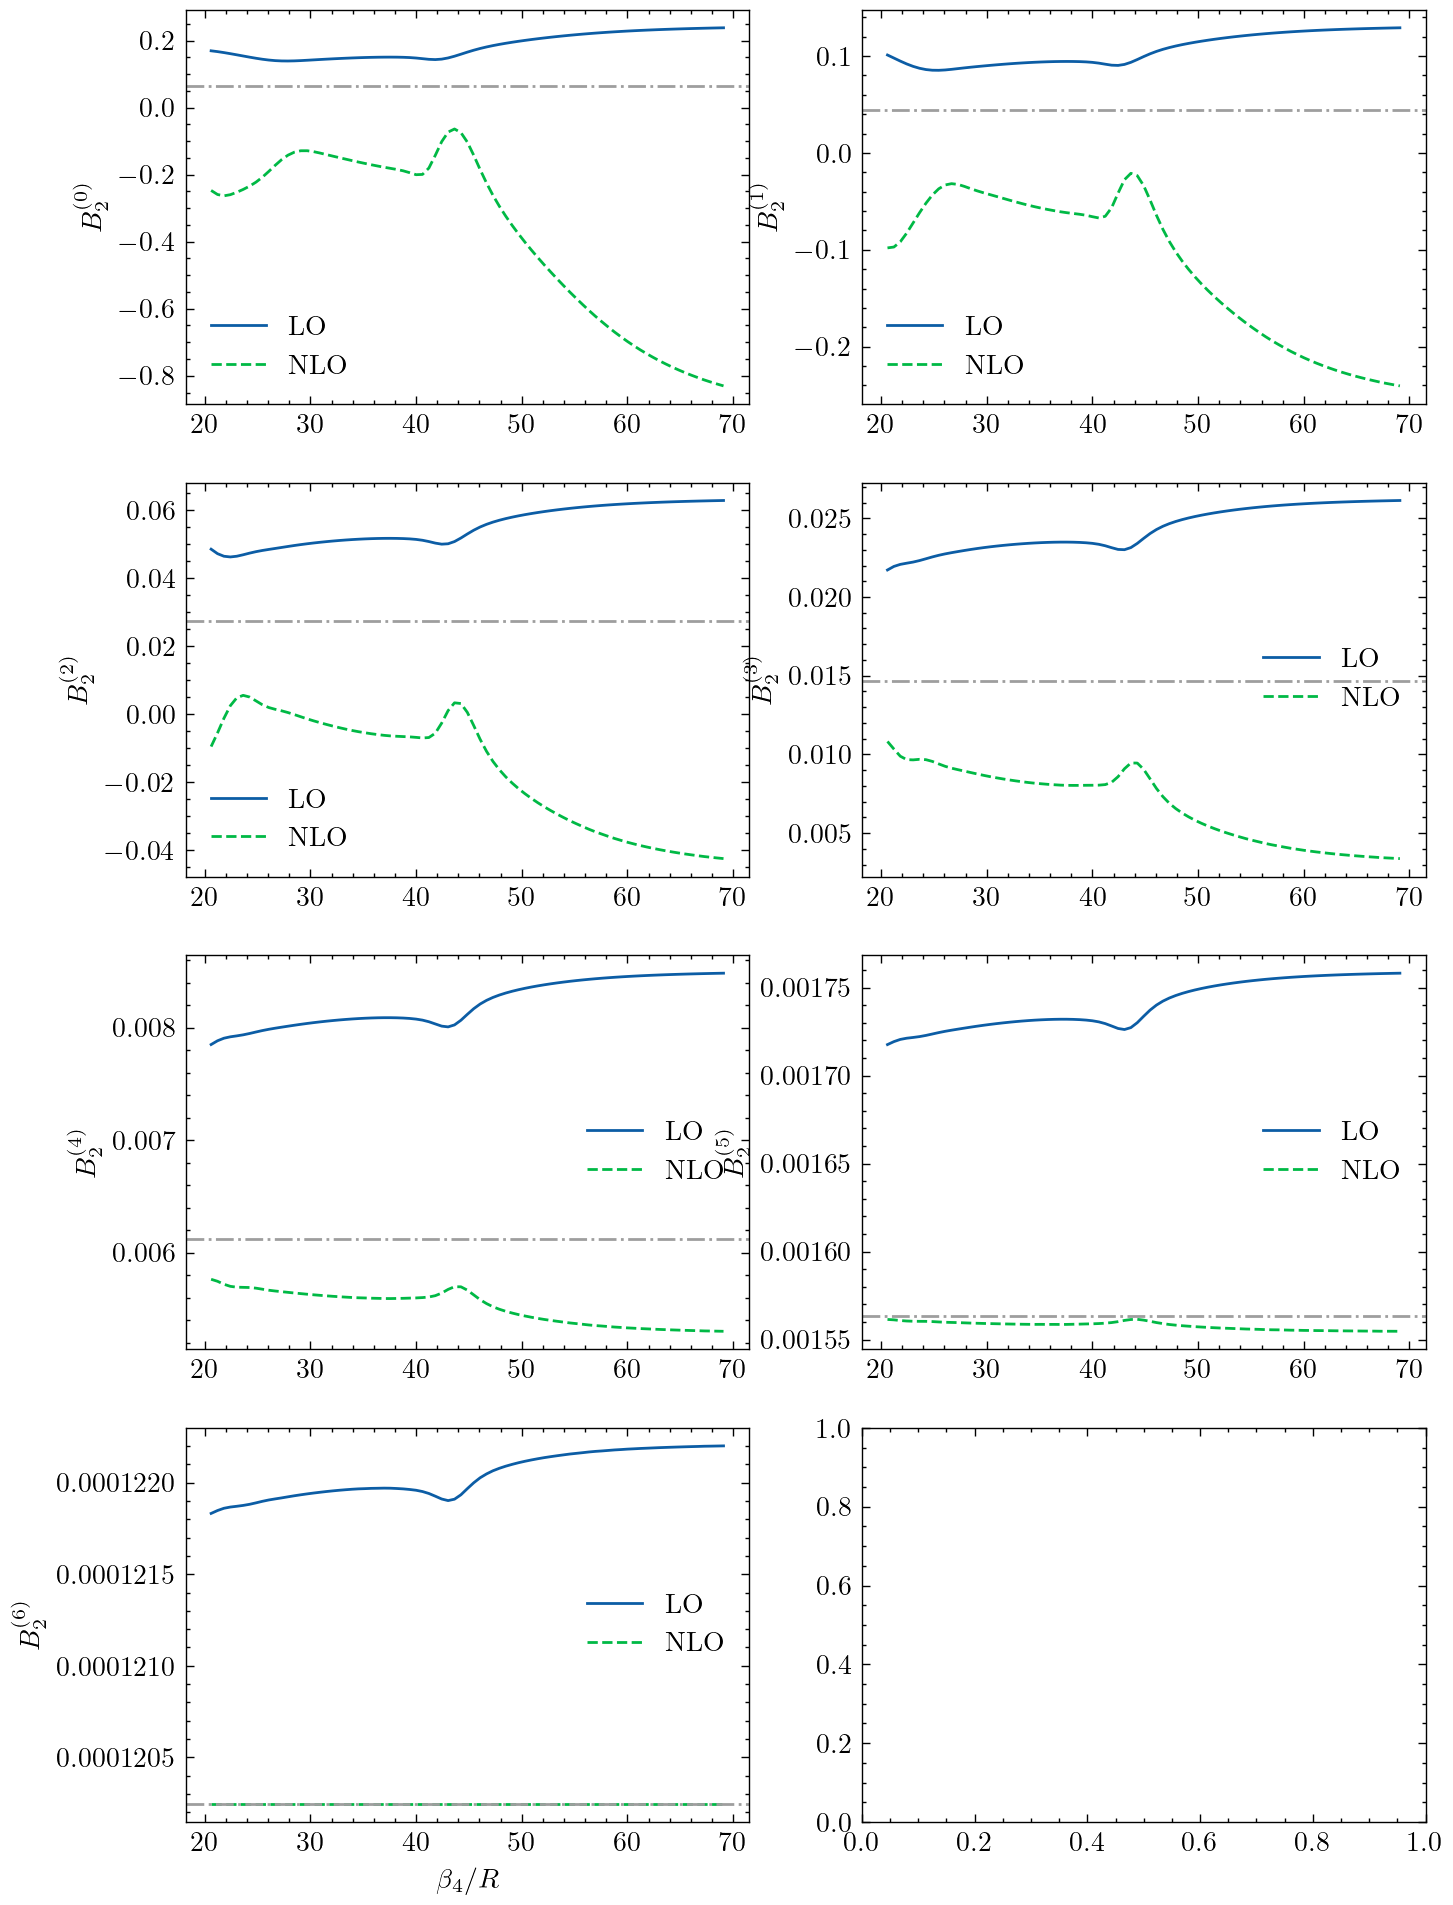

In [32]:
fig, ax = plt.subplots(4, 2, dpi=200, figsize=(2*ratio*h, 4*h))
fig.patch.set_facecolor('white')

for i in range(7):
    axij = ax[i//2, i%2]
    axij.plot(BETA4/Rs[ii], b2s_lo[ii, i], label='LO')
    axij.plot(BETA4/Rs[ii], b2s_nlo[ii, i], linestyle='--', label='NLO')
    axij.axhline(b2_mm[i], color='C6', linestyle='-.')
    axij.set_ylabel(r'$B_{2}^{(%d)}$' % (i))
    axij.legend()
#     axij.plot(BETA4/rgf_lo[:n_results, 0], np.abs(spectra_lo[:n_results, 1+i]))
    
    if i >= 6:
        ax[i//2, i%2].set_xlabel(r'$\beta_4/R$')


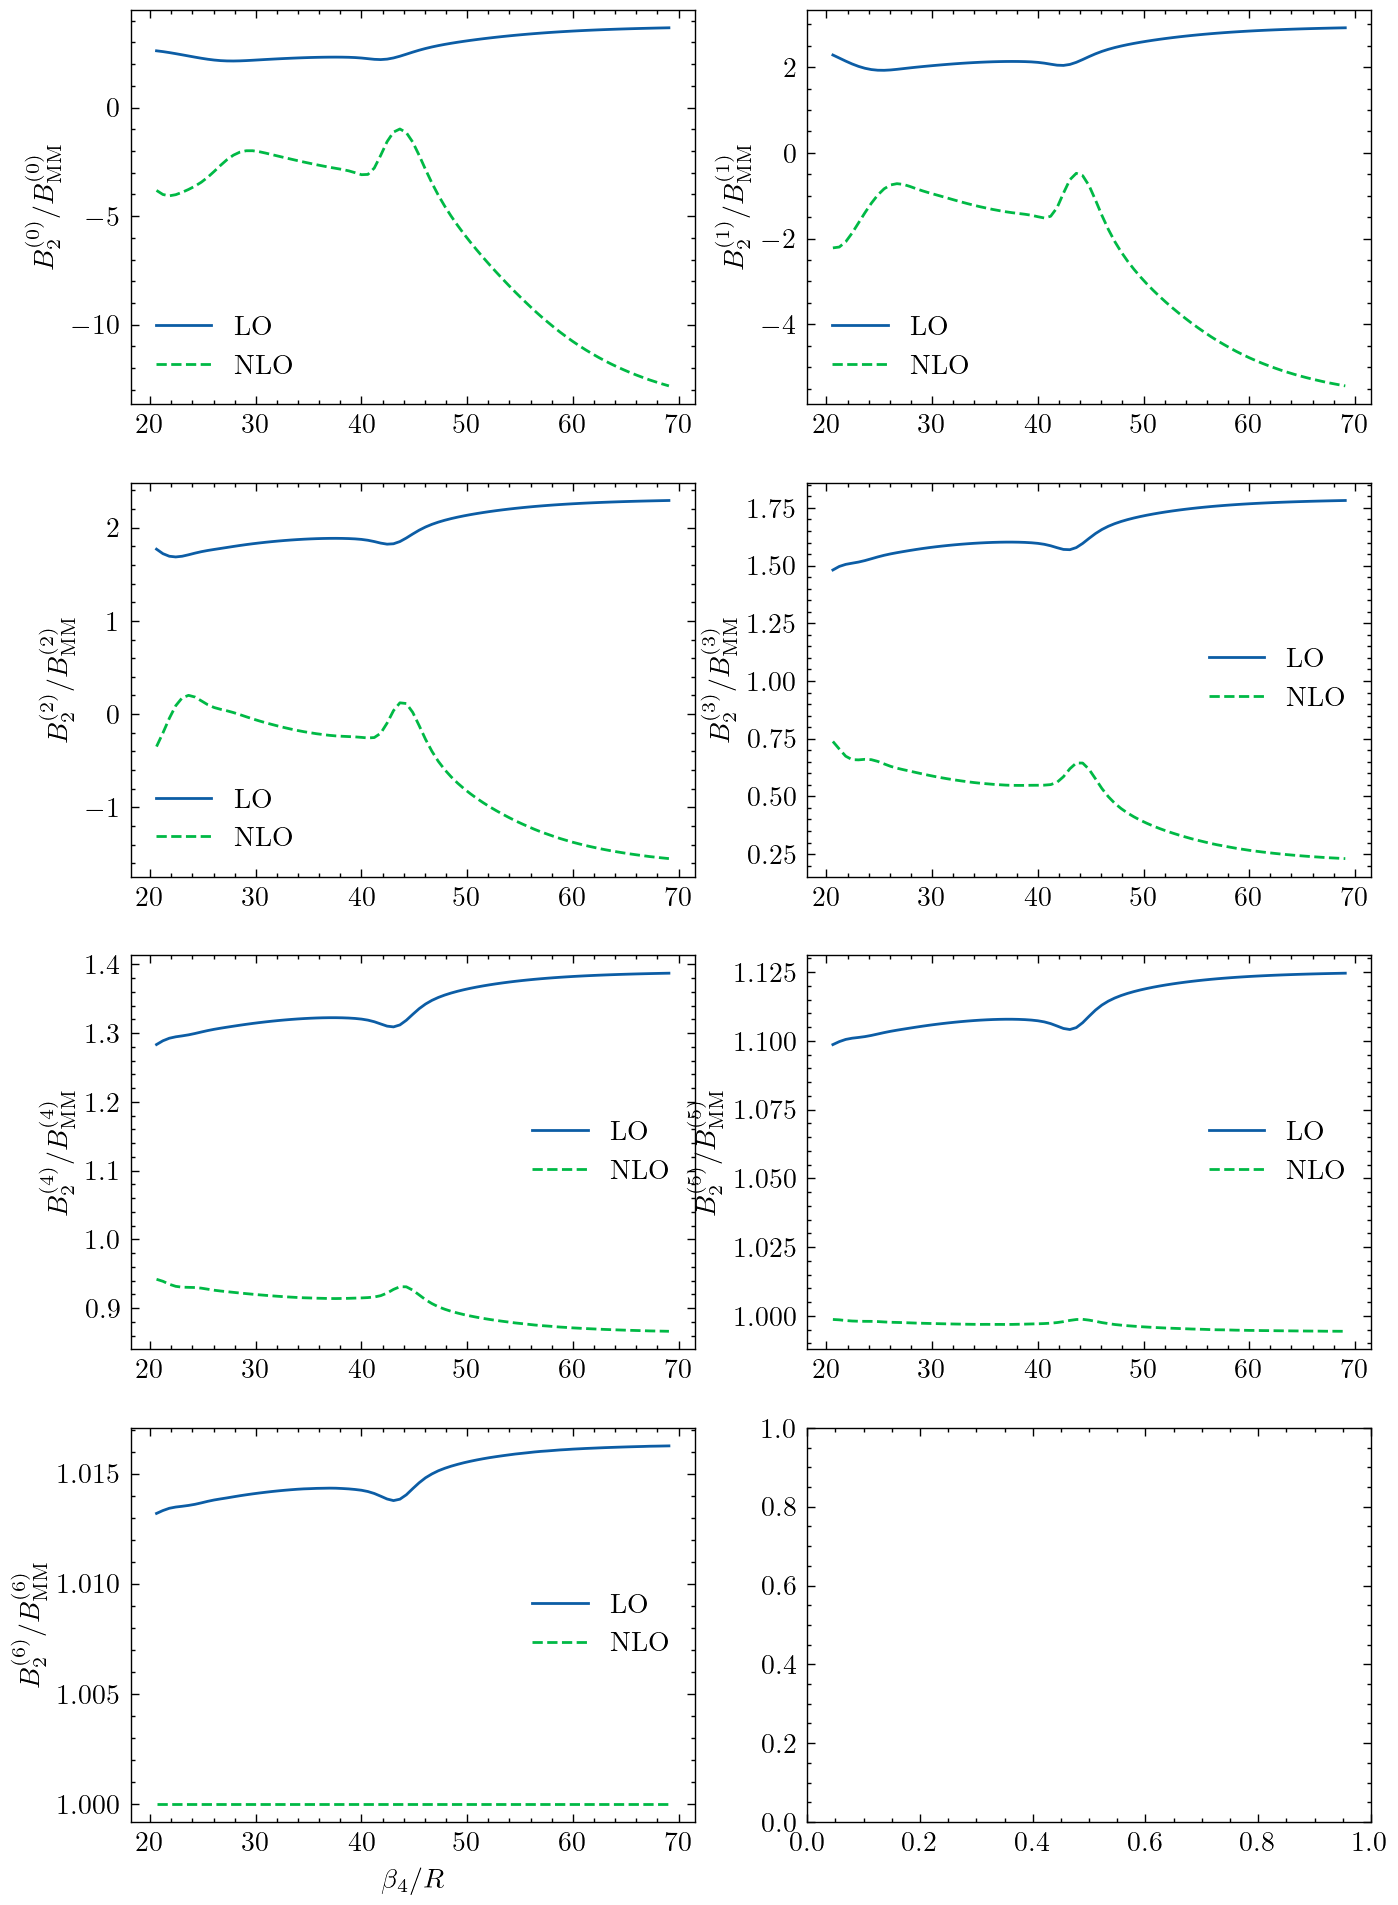

In [33]:
fig, ax = plt.subplots(4, 2, dpi=200, figsize=(2*ratio*h, 4*h))
fig.patch.set_facecolor('white')

for i in range(7):
    axij = ax[i//2, i%2]
    axij.plot(BETA4/Rs[ii], b2s_lo[ii, i] / b2_mm[i], label='LO')
    axij.plot(BETA4/Rs[ii], b2s_nlo[ii, i] / b2_mm[i], linestyle='--', label='NLO')
#     axij.axhline(b2_mm[i], color='C6', linestyle='-.')
    axij.set_ylabel(r'$B_{2}^{(%d)}/B_{\rm MM}^{(%d)}$' % (i, i))
    axij.legend()
    
    if i >= 6:
        ax[i//2, i%2].set_xlabel(r'$\beta_4/R$')


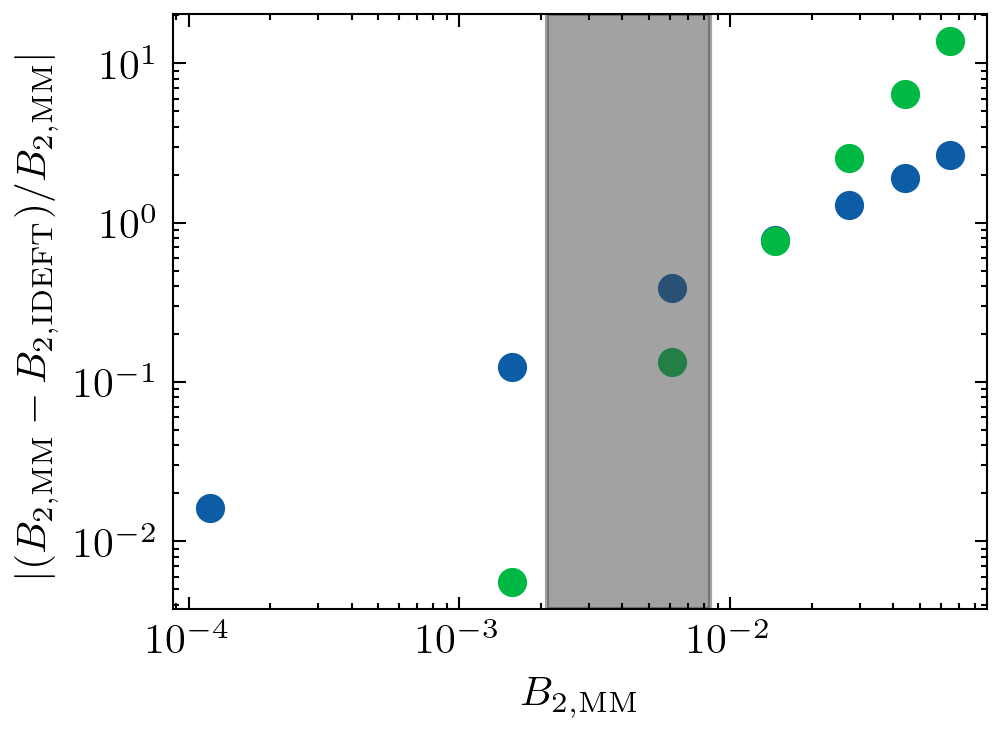

In [34]:
fig, ax = plt.subplots(dpi=300)
fig.patch.set_facecolor('white')

ax.scatter(b2_mm, np.abs((b2_mm - b2s_lo[ii[-1], :]) / b2_mm))
ax.scatter(b2_mm, np.abs((b2_mm - b2s_nlo[ii[-1], :]) / b2_mm))
ax.axvspan(1/(2*MU), 4/(2*MU), color='C5', alpha=0.5)

ax.set_xlabel(r'$B_{2,{\rm MM}}$')
ax.set_ylabel(r'$|(B_{2,{\rm MM}} - B_{2,{\rm IDEFT}})/B_{2,{\rm MM}}|$')

ax.set_yscale('log')
ax.set_xscale('log');

0.6349567439016598


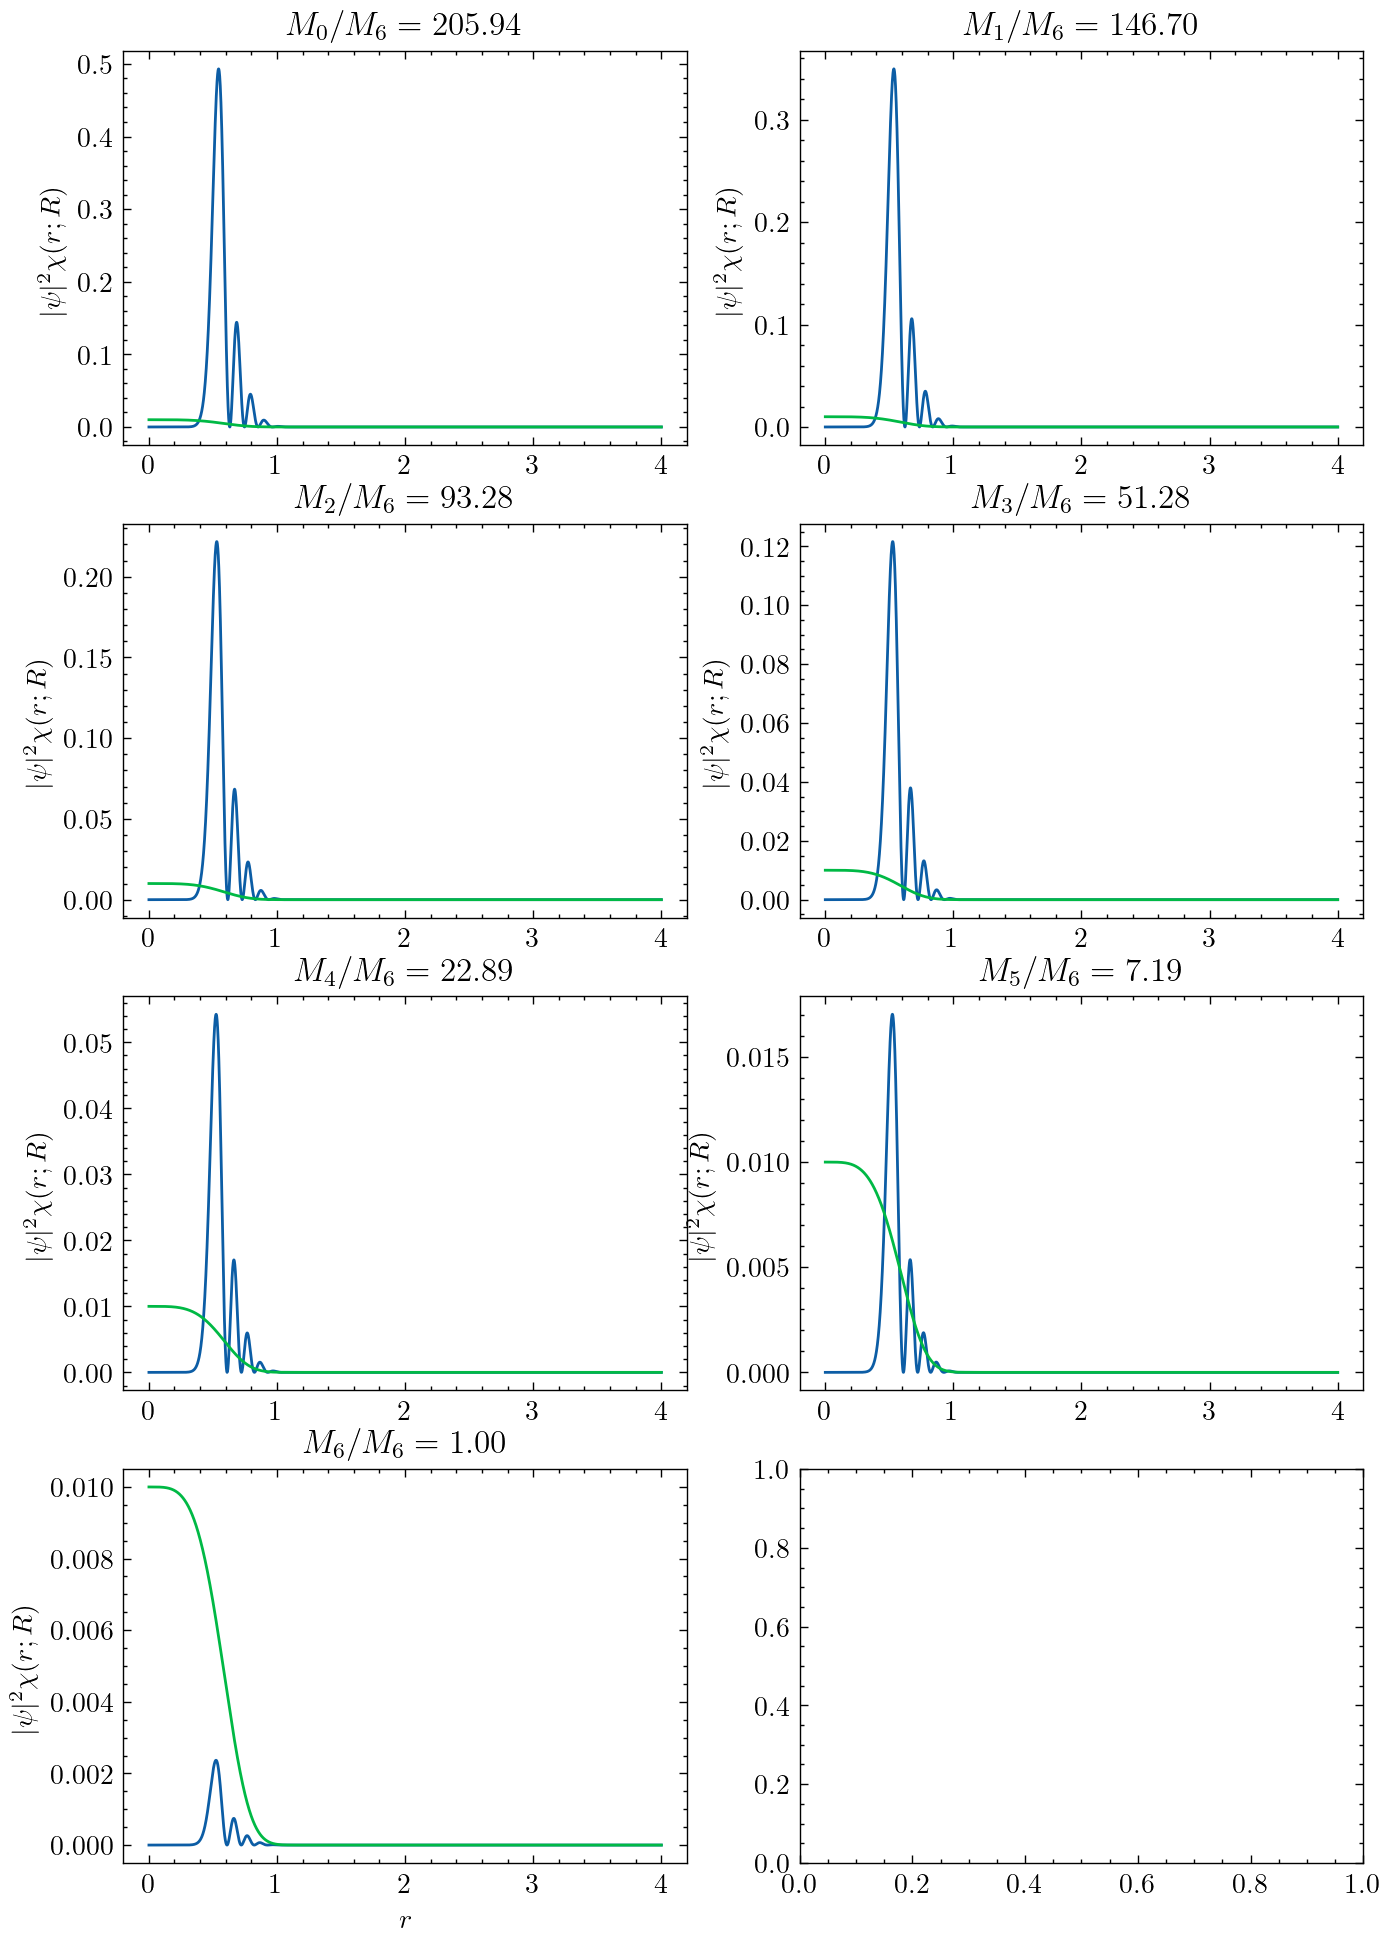

In [35]:
result = results[ii[-30]]
print(result.R)

fig, ax = plt.subplots(4, 2, dpi=200, figsize=(2*ratio*h, 4*h))
fig.patch.set_facecolor('white')

for (i, en) in enumerate(result.spec_lo):
    integrand = result.integrands[i]
    Mi = result.matrix_elements[i]
    ax[i//2, i%2].plot(R_MESH[0], integrand)
    ax[i//2, i%2].plot(R_MESH[0], local_LO_counterterm(R_MESH[0], result.R)/100)
    ax[i//2, i%2].set_title(f'$M_{i}/M_6 = {Mi/result.matrix_elements[6]:.2f}$')
    ax[i//2, i%2].set_ylabel(r'$|\psi|^2 \chi(r;R)$')
    if i >= 6:
        ax[i//2, i%2].set_xlabel(r'$r$')

In [36]:
jj = np.intersect1d(
    np.where(BETA4/Rs > 50),
    np.where(BETA4/Rs < 70)
)

In [37]:
ratios = []

for res in np.array(results)[jj]:
    me = [res.matrix_elements[i] for i in range(7)]
    ratios.append([mi / me[-1] for mi in me])

In [38]:
ratios = np.array(ratios)

In [39]:
b2s_lo = np.array([res.b2_lo for res in np.array(results)[jj]])

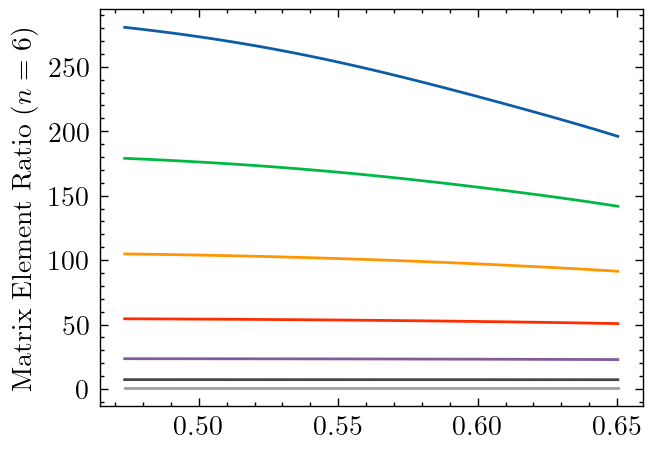

In [40]:
power = 1

fig, ax = plt.subplots(dpi=200)
fig.patch.set_facecolor('white')

for i in range(7):
    ax.plot(Rs[jj]**power, ratios[:, i])
#     ax[i//2, i%2].set_xscale('log')
#     ax[i//2, i%2].set_xlabel(r'$R^{%d}$' % (power))
    ax.set_ylabel(r'Matrix Element Ratio ($n=%d$)' % (i))

In [41]:
c2 = np.array([res.c_2 for res in results])

320.36529011749366	381.20323797223745	315.1649507497563	320.3653067524435
184.07596174055482	222.96652876778526	194.50106233289443	184.07595969511343
103.3398798391286	120.64441438140781	110.50558098046137	103.33987971578945
53.38475114987359	58.794472664923795	56.02362511353398	53.57720419820892
23.19941248213818	24.26262411835426	23.758986378477328	24.152780145954768
7.211742477399079	7.305445310134995	7.262856550087792	7.335474333035291
0.9999999349167281	1.000072748400203	1.0000427159619458	1.0177397218317392


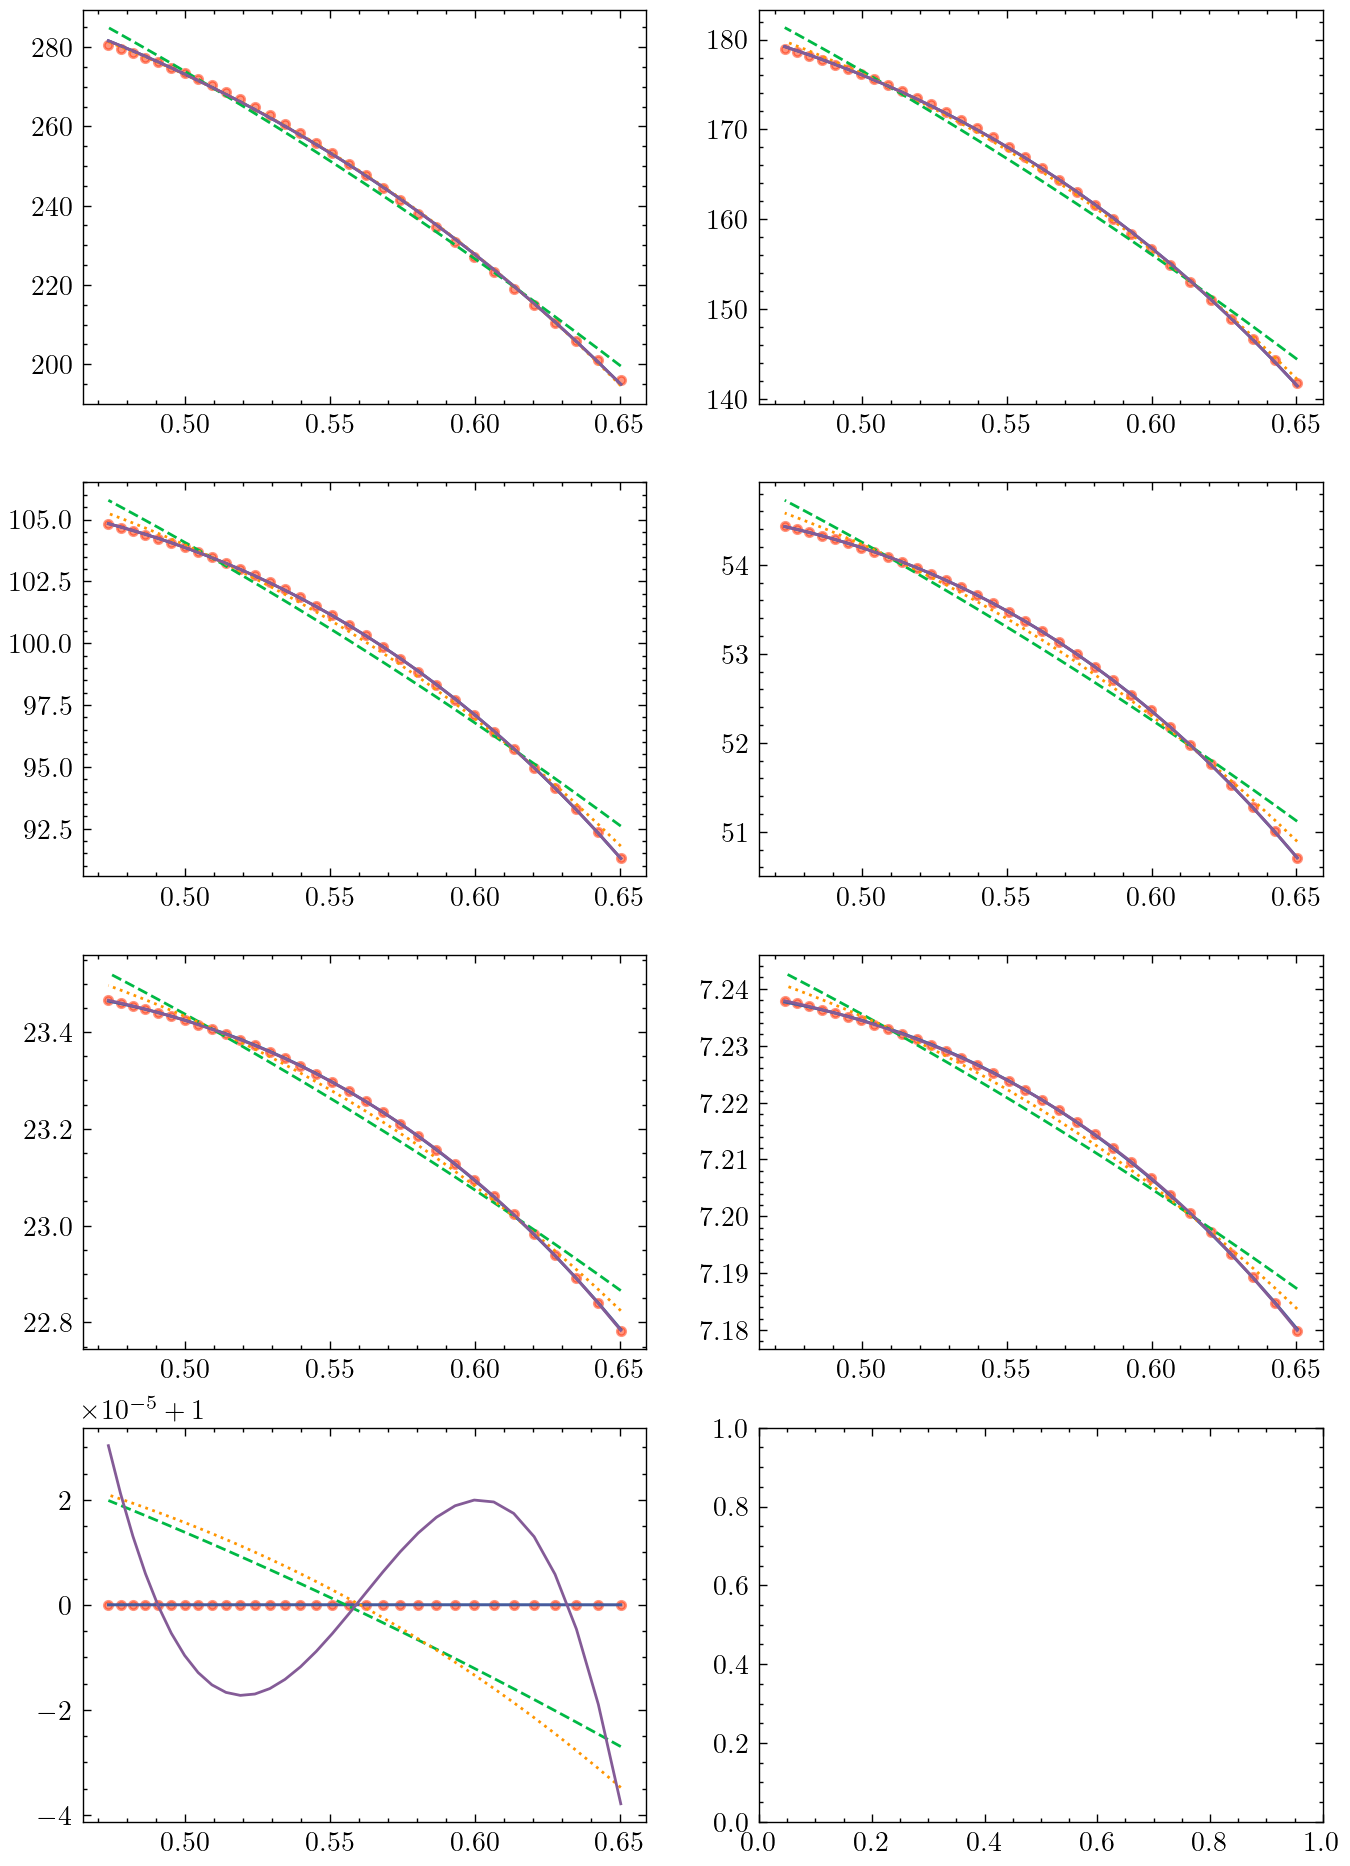

In [100]:
x = Rs[jj]

def lets_get_nuts(r, a, b, c):
    return a + b*r**2 + c*r**4


def lets_get_nuts_2(r, a, b):
    return lets_get_nuts(r, a, b, 0)


def lets_get_nuts_4(r, a, c):
    return lets_get_nuts(r, a, 0, c)


def lets_get_really_nuts(r, a, b, c, d):
    return a + b*r + c*r**2 + d*r**4


ratios_asymp = []

fig, ax = plt.subplots(4, 2, figsize=(2*4, 4*3), dpi=200)
fig.patch.set_facecolor('white')

for i in range(7):
    y = ratios[:, i]
    
    bds = optimize.Bounds([-np.inf, -np.inf, -np.inf], [np.inf, np.inf, np.inf])
    pars, cov, infodict, _, _ = optimize.curve_fit(lets_get_nuts, x, y, full_output=True, bounds=bds)
#     print(np.sqrt(np.sum(infodict['fvec']**2)), pars[0], end='\t')
    print(pars[0], end='\t')
    ax[i//2, i%2].plot(x, y, color='C3', marker='.', alpha=0.5, linestyle='')
    ax[i//2, i%2].plot(x, lets_get_nuts(x, *pars), linestyle='-', color='C0')
    
    xp = np.linspace(x[0], 1*x[-1], 100)
    ax[i//2, i%2].plot(xp, lets_get_nuts(xp, *pars), linestyle='-', color='C4', alpha=0.5)
    
    bds = optimize.Bounds([-np.inf, -np.inf], [np.inf, 0])
    pars, cov, infodict, _, _ = optimize.curve_fit(lets_get_nuts_2, x, y, full_output=True, bounds=bds)
#     print(np.sqrt(np.sum(infodict['fvec']**2)), end='\t')
    print(pars[0], end='\t')
    ax[i//2, i%2].plot(x, lets_get_nuts_2(x, *pars), linestyle='--', color='C1')
    
    pars, cov, infodict, _, _ = optimize.curve_fit(lets_get_nuts_4, x, y, full_output=True, bounds=bds)
#     print(np.sqrt(np.sum(infodict['fvec']**2)), pars[0], end='\n\n')
    print(pars[0], end='\t')
    ax[i//2, i%2].plot(x, lets_get_nuts_4(x, *pars), linestyle=':', color='C2')
    
    bds = optimize.Bounds([-np.inf, -np.inf, -np.inf, -np.inf], [np.inf, 0, np.inf, 0])
    pars, cov, infodict, _, _ = optimize.curve_fit(lets_get_really_nuts, x, y, full_output=True, bounds=bds)
    ratios_asymp.append(pars[0])
#     print(np.sqrt(np.sum(infodict['fvec']**2)), pars[0], end='\t')
    print(pars[0], end='\n')
    ax[i//2, i%2].plot(x, lets_get_really_nuts(x, *pars), linestyle='-', color='C4')

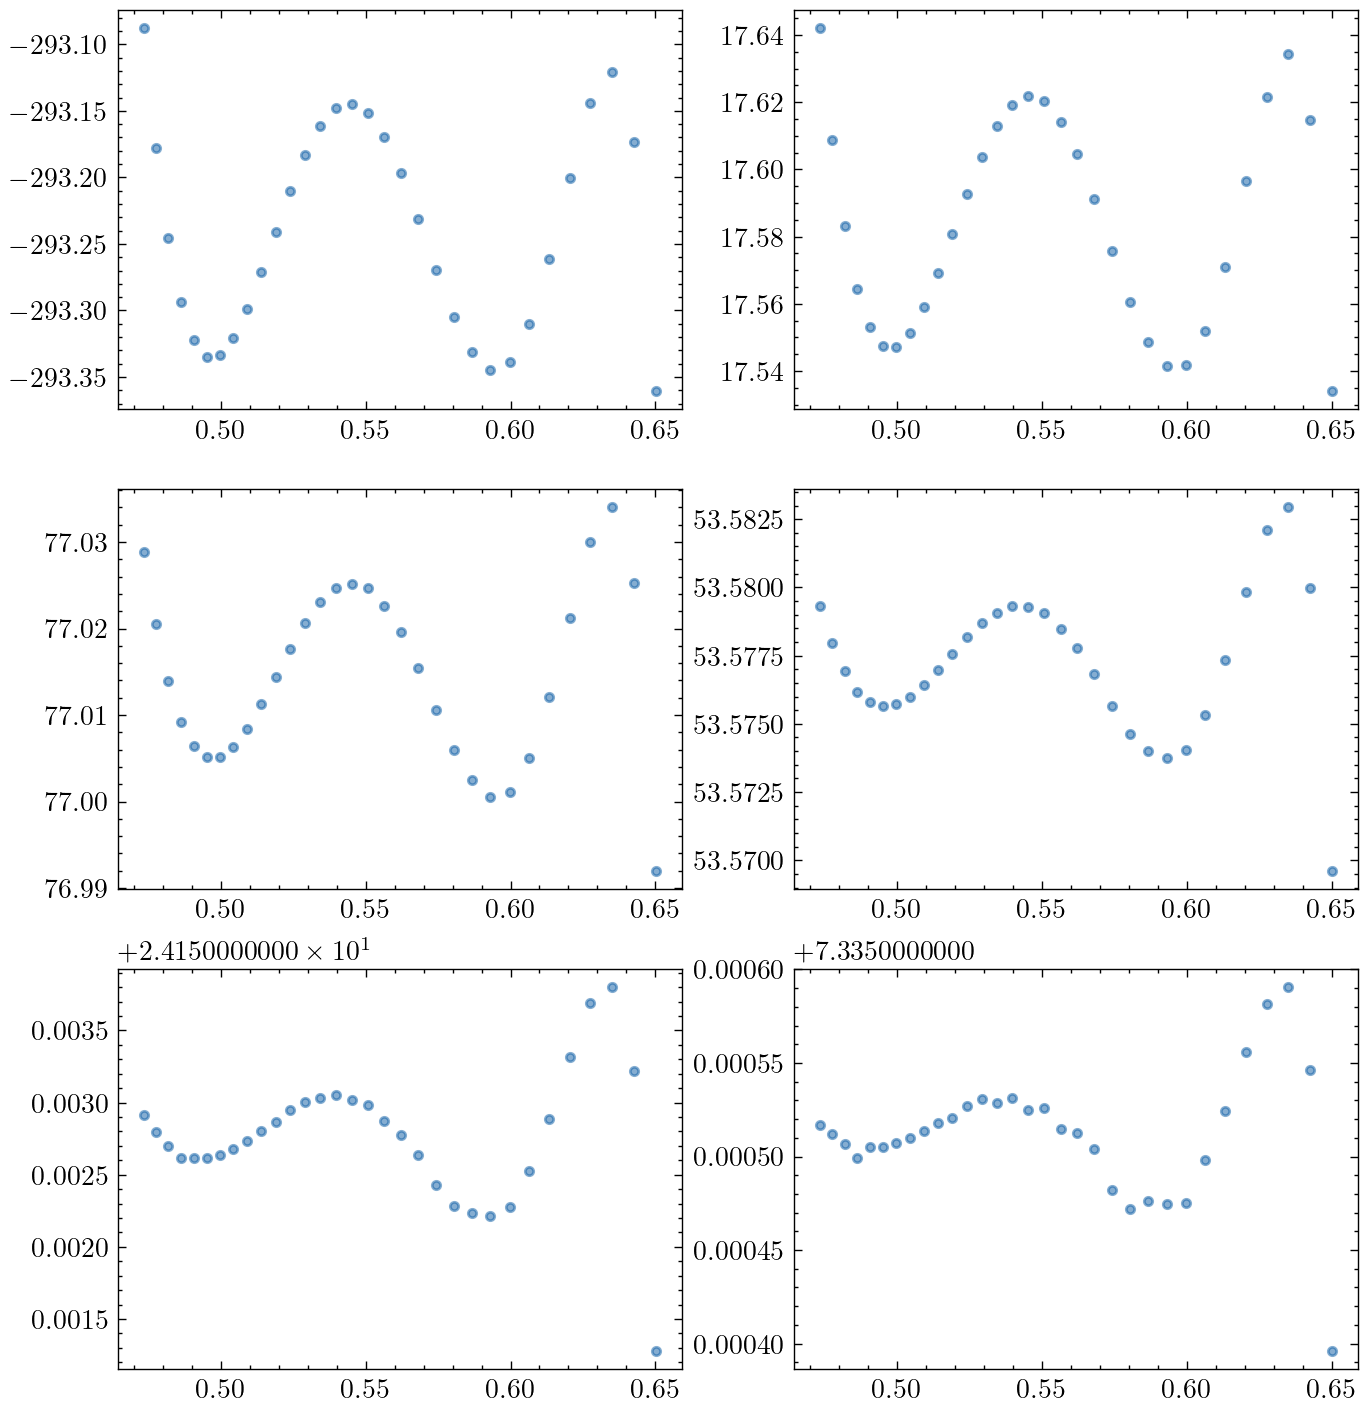

In [101]:
fig, ax = plt.subplots(3, 2, figsize=(2*4, 3*3), dpi=200)
fig.patch.set_facecolor('white')

for i in range(6):
    y = ratios[:, i]
    
#     bds = optimize.Bounds([-np.inf, -np.inf, -np.inf, -np.inf], [np.inf, 0, np.inf, 0])
    pars, cov, infodict, _, _ = optimize.curve_fit(lets_get_really_nuts, x, y, full_output=True)
#     ax[i//2, i%2].plot(x, lets_get_nuts(x, *pars), linestyle='-', color='C0')
    ax[i//2, i%2].plot(x, y - lets_get_really_nuts(x, 0, *pars[1:]), color='C0', marker='.', alpha=0.5, linestyle='')

In [97]:
np.savetxt('ratios_asymp.txt', ratios_asymp)

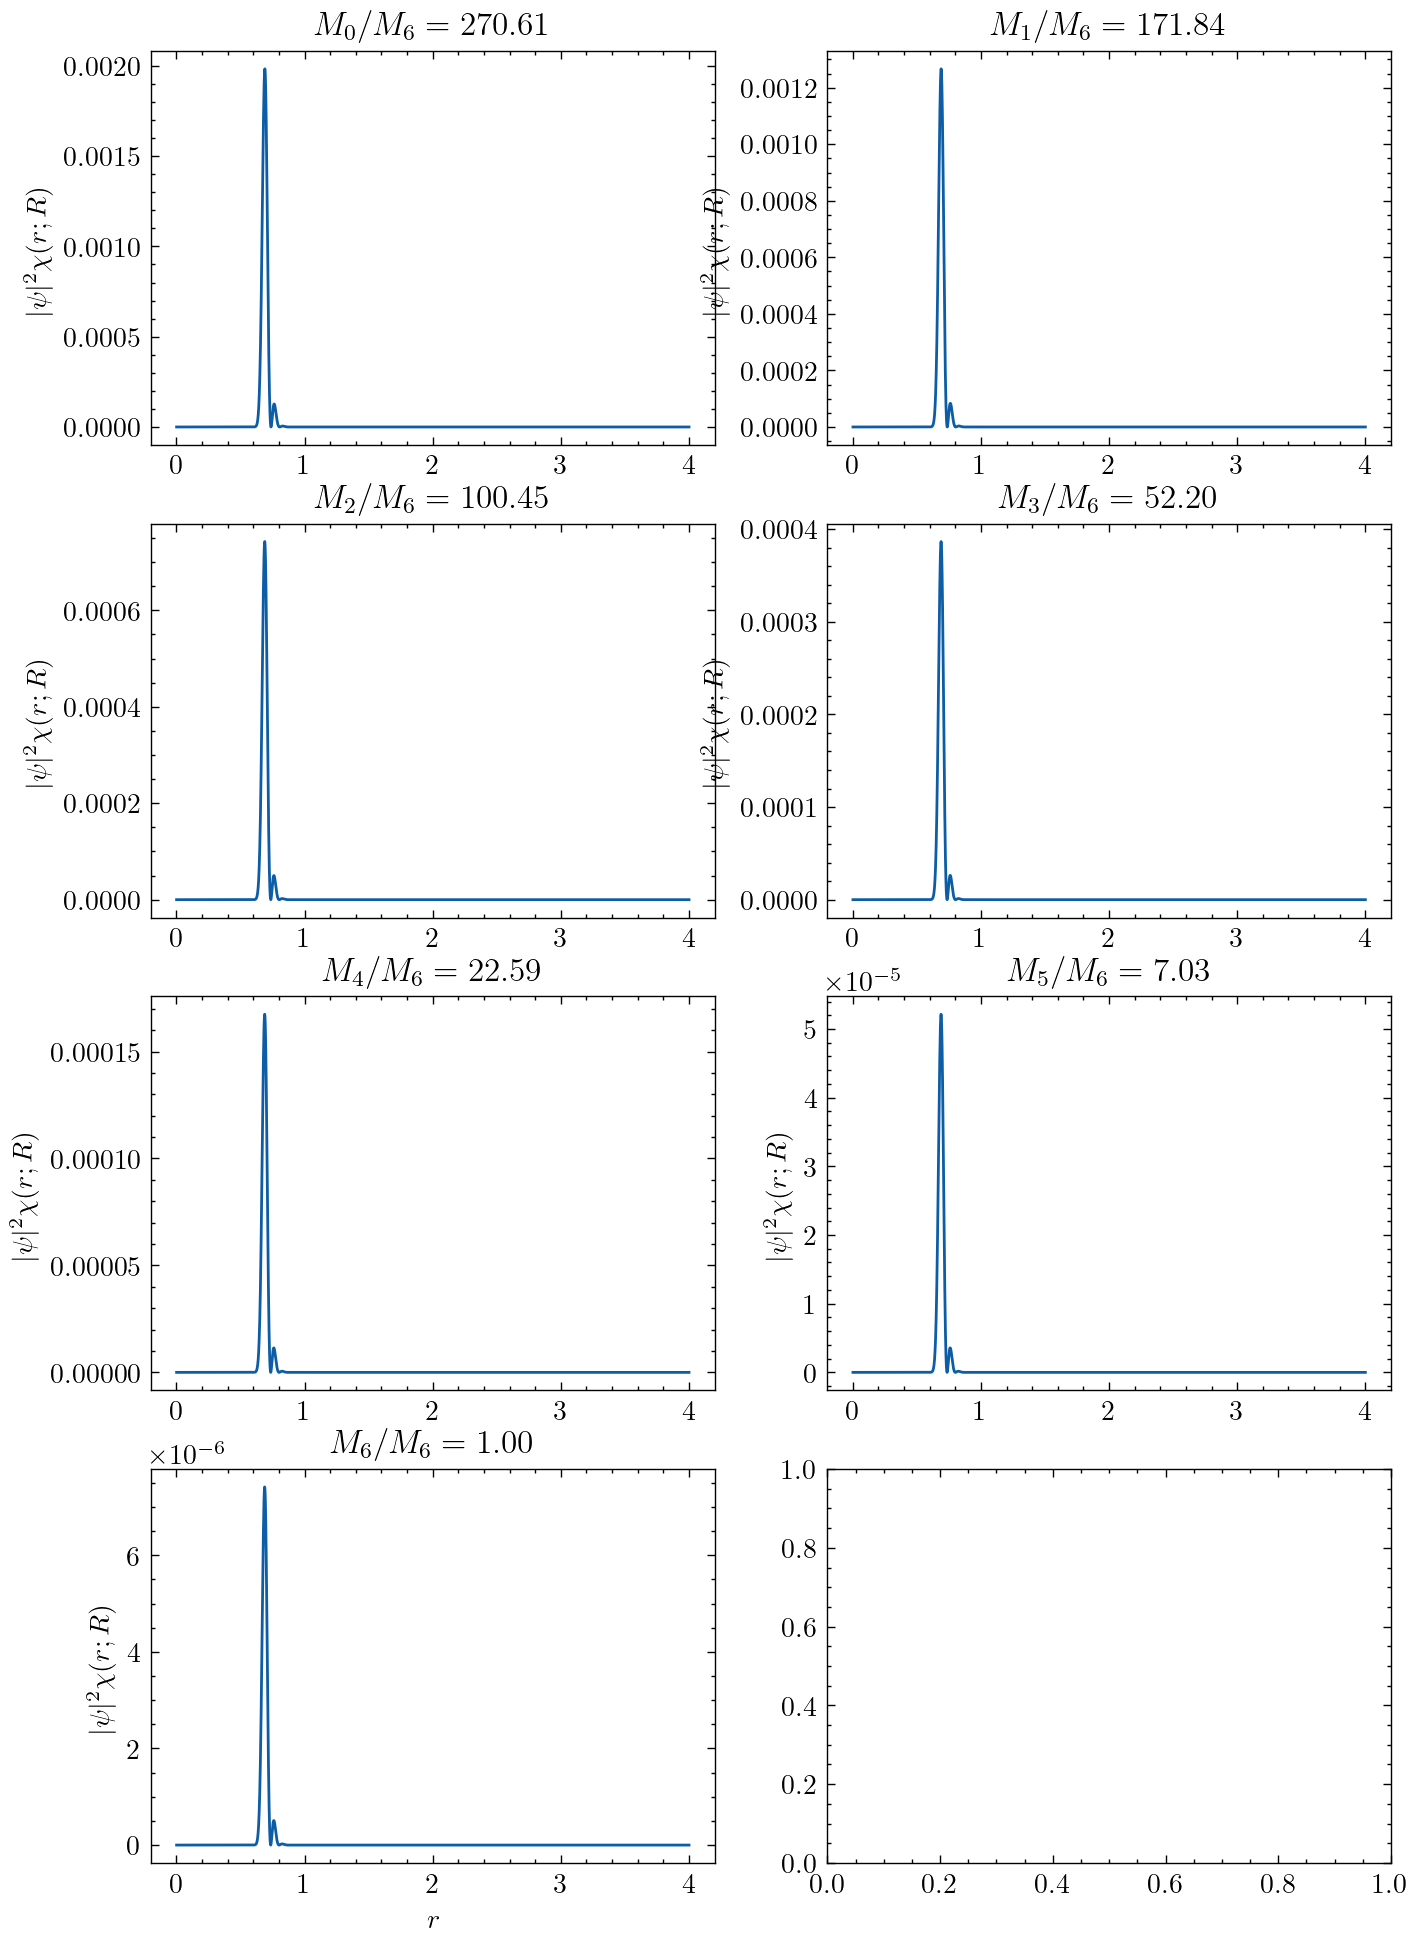

In [256]:
result = results[-10]

fig, ax = plt.subplots(4, 2, dpi=200, figsize=(2*ratio*h, 4*h))
fig.patch.set_facecolor('white')

for (i, en) in enumerate(result.spec_lo):
    integrand = result.integrands[i]
    Mi = result.matrix_elements[i]
    ax[i//2, i%2].plot(R_MESH[0], integrand)
    ax[i//2, i%2].set_title(f'$M_{i}/M_6 = {Mi/result.matrix_elements[6]:.2f}$')
    ax[i//2, i%2].set_ylabel(r'$|\psi|^2 \chi(r;R)$')
    if i >= 6:
        ax[i//2, i%2].set_xlabel(r'$r$')

In [257]:
rgf_nlo = np.array([[res.R, res.c_2] for res in results])

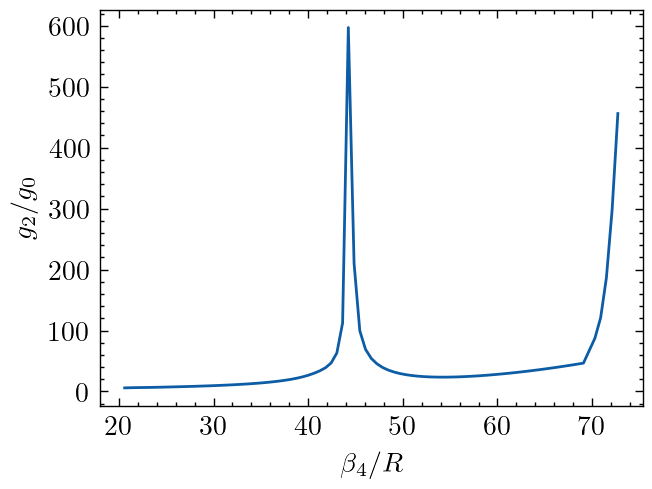

In [258]:
fig, ax = plt.subplots(dpi=200)
fig.patch.set_facecolor('white')

ax.plot(BETA4/rgf_nlo[:, 0], np.abs(rgf_nlo[:, 1] / rgf_lo[:-1, 1]))

ax.set_ylabel(r'$g_2/g_0$')
ax.set_xlabel(r'$\beta_4/R$');

In [260]:
np.savetxt(f'rgflow_local_nlo_a0_B6_fix_coord_hp_n_{NUM_STATES}_coord_ir_corrected_R4.txt', rgf_nlo)

np.savetxt(f'spectra_local_nlo_a0_B6_fix_coord_hp_n_{NUM_STATES}_coord_ir_corrected_R4.txt', np.vstack((rgf_nlo[:, 0], b2s_nlo.T)).T)